In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline


In [3]:
# Initialize SparkSession with specific resource configurations for distributed computing
spark = SparkSession.builder \
    .appName("Spark HDFS File Import") \  # Name of the Spark application
    .config("spark.master", "spark://10.128.0.2:7077") \  # URL of the Spark master node
    .config("spark.hadoop.fs.defaultFS", "hdfs://10.128.0.2:54310") \  # HDFS URI for file storage
    .config("spark.executor.memory", "4g") \  # Allocate 4GB of memory per executor
    .config("spark.driver.memory", "4g") \  # Allocate 4GB of memory for the driver
    .config("spark.executor.cores", "2") \  # Use 2 CPU cores per executor
    .config("spark.driver.cores", "2") \  # Use 2 CPU cores for the driver
    .config("spark.sql.shuffle.partitions", "8") \  # Set the number of partitions for shuffling data
    .getOrCreate()  # Create the SparkSession object

# Print the version of Spark to confirm that the session is initialized correctly
print(f"Spark Version: {spark.version}")
print("SparkSession initialized with resources.")


Spark Version: 3.5.2
SparkSession initialized with resources.


In [4]:
# Define HDFS paths for the files

train_path = "hdfs://10.128.0.2:54310/microsoft/train.csv"

print("File paths defined.")


File paths defined.


In [5]:
try:
    # Attempt to read the CSV file into a DataFrame using Spark
    microsft_df = spark.read \
        .option("header", "true") \  # Specify that the CSV file has a header row
        .option("inferSchema", "true") \  # Enable automatic schema inference for the data types
        .csv(train_path)  # Load the CSV file from the specified path into a DataFrame

    # Display the first 5 rows of the DataFrame to verify the data is loaded correctly
    print("Microsoft DataFrame:")
    microsft_df.show(5)
    print("File loaded successfully.")
except Exception as e:
    # Print an error message if the file loading fails
    print(f"Error: {e}")


Microsoft DataFrame:


24/08/20 02:47:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------+-------------+---------------+------------+------+----------------+----------------+-------------------------+-------------------------+-------------------+-----------------+------+-----------------+--------------+----------------------+-----------------+---------------------------+---------+---------+--------+-------+-------+--------------------+--------------------+----------+-----------+---------------+-------+-----+---------------+------------+--------+------------+---------------------+-------------------+------------------------+-------------------------+-------------------------+--------------------------------------+-------------------------------+---------------------+-------------------------------+--------------------------+--------------------------------+--------------------------+-----------------------+----------------------+-------------------------------------------------+-------------------------------------------------+-------------

In [6]:

# Print schema for Microsft DataFrame
print("Microsft DataFrame Schema:")
microsft_df.printSchema()



Microsft DataFrame Schema:
root
 |-- MachineIdentifier: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- EngineVersion: string (nullable = true)
 |-- AppVersion: string (nullable = true)
 |-- AvSigVersion: string (nullable = true)
 |-- IsBeta: integer (nullable = true)
 |-- RtpStateBitfield: integer (nullable = true)
 |-- IsSxsPassiveMode: integer (nullable = true)
 |-- DefaultBrowsersIdentifier: integer (nullable = true)
 |-- AVProductStatesIdentifier: integer (nullable = true)
 |-- AVProductsInstalled: integer (nullable = true)
 |-- AVProductsEnabled: integer (nullable = true)
 |-- HasTpm: integer (nullable = true)
 |-- CountryIdentifier: integer (nullable = true)
 |-- CityIdentifier: integer (nullable = true)
 |-- OrganizationIdentifier: integer (nullable = true)
 |-- GeoNameIdentifier: integer (nullable = true)
 |-- LocaleEnglishNameIdentifier: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Processor: string (nullable = true)
 |-- OsV

In [7]:
# Select the relevant columns for the analysis: Platform, Processor, Census_TotalPhysicalRAM, and HasDetections
microsft_df = microsft_df.select('Platform', 'Processor', 'Census_TotalPhysicalRAM', 'HasDetections')

# Convert 'Census_TotalPhysicalRAM' to float for accurate numerical operations
microsft_df = microsft_df.withColumn("Census_TotalPhysicalRAM", col("Census_TotalPhysicalRAM").cast("float"))

# Convert 'HasDetections' to integer to ensure it's treated as binary data (0 or 1)
microsft_df = microsft_df.withColumn("HasDetections", col("HasDetections").cast("integer"))


In [8]:
microsft_df.show(5)

+---------+---------+-----------------------+-------------+
| Platform|Processor|Census_TotalPhysicalRAM|HasDetections|
+---------+---------+-----------------------+-------------+
|windows10|      x64|                 4096.0|            0|
|windows10|      x64|                 4096.0|            0|
|windows10|      x64|                 4096.0|            0|
|windows10|      x64|                 4096.0|            1|
|windows10|      x64|                 6144.0|            1|
+---------+---------+-----------------------+-------------+
only showing top 5 rows



In [9]:
# Count the total number of records in the DataFrame
total_records = microsft_df.count()
print(f"Total number of records: {total_records}")


Total number of records: 8921483


In [10]:
from pyspark.sql.functions import col, count, when, isnan

# Count null values in each column
null_counts = microsft_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in microsft_df.columns])
null_counts.show()


+--------+---------+-----------------------+-------------+
|Platform|Processor|Census_TotalPhysicalRAM|HasDetections|
+--------+---------+-----------------------+-------------+
|       0|        0|                  80533|            0|
+--------+---------+-----------------------+-------------+



In [11]:
from pyspark.sql.functions import col, desc

def top_three_values(df, column_name):
    # Group by the specified column and count occurrences
    return df.groupBy(column_name).count().orderBy(desc("count")).limit(3)


In [12]:
# Columns to analyze
columns_to_analyze = ['Platform', 'Processor', 'Census_TotalPhysicalRAM', 'HasDetections']

# Loop through columns and apply the function
for column in columns_to_analyze:
    print(f"Top 3 unique values for {column}:")
    top_three_values(microsft_df, column).show()


Top 3 unique values for Platform:


+---------+-------+
| Platform|  count|
+---------+-------+
|windows10|8618715|
| windows8| 194508|
| windows7|  93889|
+---------+-------+

Top 3 unique values for Processor:


+---------+-------+
|Processor|  count|
+---------+-------+
|      x64|8105435|
|      x86| 815702|
|    arm64|    346|
+---------+-------+

Top 3 unique values for Census_TotalPhysicalRAM:


+-----------------------+-------+
|Census_TotalPhysicalRAM|  count|
+-----------------------+-------+
|                 4096.0|4094512|
|                 8192.0|2196505|
|                 2048.0|1097474|
+-----------------------+-------+

Top 3 unique values for HasDetections:


+-------------+-------+
|HasDetections|  count|
+-------------+-------+
|            0|4462591|
|            1|4458892|
+-------------+-------+



In [13]:
from pyspark.sql.functions import col

# Transform Census_TotalPhysicalRAM from MB to GB
microsft_df = microsft_df.withColumn("Census_TotalPhysicalRAM_GB", col("Census_TotalPhysicalRAM") / 1024)


In [14]:
from pyspark.sql.functions import when

# Convert HasDetections from integer (0, 1) to boolean (True, False)
microsft_df = microsft_df.withColumn("HasDetectionsBool", when(col("HasDetections") == 1, True).otherwise(False))


In [15]:
# Drop the old columns 
microsft_df = microsft_df.drop("Census_TotalPhysicalRAM", "HasDetections")


In [16]:
microsft_df.show()

+---------+---------+--------------------------+-----------------+
| Platform|Processor|Census_TotalPhysicalRAM_GB|HasDetectionsBool|
+---------+---------+--------------------------+-----------------+
|windows10|      x64|                       4.0|            false|
|windows10|      x64|                       4.0|            false|
|windows10|      x64|                       4.0|            false|
|windows10|      x64|                       4.0|             true|
|windows10|      x64|                       6.0|             true|
|windows10|      x64|                       8.0|             true|
|windows10|      x64|                       4.0|             true|
|windows10|      x64|                       4.0|            false|
|windows10|      x64|                       4.0|            false|
|windows10|      x64|                       8.0|             true|
|windows10|    arm64|                       4.0|            false|
|windows10|      x64|                       4.0|             t

In [17]:
from pyspark.sql.functions import mean, col

# Calculate the mean of the column and round it
mean_value = microsft_df.select(mean(col("Census_TotalPhysicalRAM_GB"))).collect()[0][0]
rounded_mean_value = round(mean_value)

# # Replace nulls with the rounded mean value
microsft_df = microsft_df.na.fill({"Census_TotalPhysicalRAM_GB": rounded_mean_value})



#  Hierarchical clustering

In [59]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml import Pipeline


In [60]:
# Convert the 'Processor' column from categorical text to numeric indices
indexer = StringIndexer(inputCol="Processor", outputCol="ProcessorIndex")

# Combine the 'ProcessorIndex' and 'Census_TotalPhysicalRAM_GB' columns into a single feature vector
assembler = VectorAssembler(inputCols=["ProcessorIndex", "Census_TotalPhysicalRAM_GB"], outputCol="features")


In [61]:
# Initialize the Bisecting K-Means clustering algorithm, setting it to create 5 clusters
bkm = BisectingKMeans().setK(5).setSeed(1)


In [63]:
pipeline = Pipeline(stages=[indexer, assembler, bkm])
model = pipeline.fit(microsft_df)


24/08/20 01:04:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [65]:
# Create a pipeline that combines the steps: indexing, assembling features, and clustering
pipeline = Pipeline(stages=[indexer, assembler, bkm])

# Fit the pipeline to the data to train the model using the steps defined
model = pipeline.fit(microsft_df)


+---------+---------+--------------------------+----------+
| Platform|Processor|Census_TotalPhysicalRAM_GB|prediction|
+---------+---------+--------------------------+----------+
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       6.0|         2|
|windows10|      x64|                       8.0|         3|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       8.0|         3|
|windows10|    arm64|                       4.0|         1|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                       4.0|         1|
|windows10|      x64|                   

In [66]:
# Extract the cluster centers from the trained Bisecting K-Means model
centers = model.stages[-1].clusterCenters()

# Print the cluster centers to understand the centroid locations of each cluster
print("Cluster Centers: ")
for center in centers:
    print(center)


Cluster Centers: 
[0.43013523 2.06528592]
[0.05003476 3.99984014]
[0.04025691 5.98747919]
[6.74008530e-03 8.28009493e+00]
[1.67504729e-03 1.86149407e+01]


# K-MEANS CLUSTERING

In [67]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [70]:
# Convert the 'Processor' column into a numerical format by indexing each unique category
indexer = StringIndexer(inputCol="Processor", outputCol="ProcessorIndex")

# Combine 'ProcessorIndex' and 'Census_TotalPhysicalRAM_GB' into a single feature vector for machine learning
assembler = VectorAssembler(inputCols=["ProcessorIndex", "Census_TotalPhysicalRAM_GB"], outputCol="features")


In [71]:
# Initialize the K-Means clustering algorithm to create 5 clusters
kmeans = KMeans().setK(5).setSeed(1)


In [73]:
# Create a pipeline that sequentially applies the indexing, feature assembly, and K-Means clustering
pipeline = Pipeline(stages=[indexer, assembler, kmeans])

# Fit the pipeline to the data, training the K-Means model with the transformed features
model = pipeline.fit(microsft_df)


In [75]:
# Apply the trained model to the data to assign each data point to a cluster
predictions = model.transform(microsft_df)


In [76]:
# Initialize the ClusteringEvaluator to assess the quality of clustering
evaluator = ClusteringEvaluator()

# Calculate the silhouette score to measure how well the clusters are formed
silhouette = evaluator.evaluate(predictions)

# Print the silhouette score, which indicates the clustering quality
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.8890394360452937


In [77]:
# Display the relevant columns from the predictions DataFrame to review the clustering results
predictions.select("Platform", "Processor", "Census_TotalPhysicalRAM_GB", "prediction").show()


+---------+---------+--------------------------+----------+
| Platform|Processor|Census_TotalPhysicalRAM_GB|prediction|
+---------+---------+--------------------------+----------+
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       6.0|         0|
|windows10|      x64|                       8.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       8.0|         0|
|windows10|    arm64|                       4.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                       4.0|         0|
|windows10|      x64|                   

In [79]:
#KMeans model last stage in the pipeline
kmeans_model = model.stages[-1]  # Adjust the index if your KMeans model is at a different position in the pipeline stages


In [81]:
# Extract the centers of the clusters from the K-Means model
centers = kmeans_model.clusterCenters()

# Print the cluster centers to review the centroids of each cluster
print("Cluster Centers: ")
for center in centers:
    print(center)


Cluster Centers: 
[0.10018758 4.88515849]
[2.39309213e-03 1.50256643e+01]
[2.41837969e-04 7.66650915e+01]
[  0.         561.25490196]
[9.60922486e-04 3.09599381e+01]


In [82]:
# Group the data by cluster assignment and count the number of data points in each cluster
cluster_counts = predictions.groupBy("prediction").count()

# Display the count of data points for each cluster
cluster_counts.show()


+----------+-------+
|prediction|  count|
+----------+-------+
|         1| 710378|
|         3|     51|
|         4|  71806|
|         2|   8270|
|         0|8130978|
+----------+-------+



In [83]:
from pyspark.sql.functions import col, avg

# Calculate average RAM per cluster
avg_ram_per_cluster = predictions.groupBy("prediction").agg(avg("Census_TotalPhysicalRAM_GB").alias("Average_RAM"))
avg_ram_per_cluster.show()

# Count the number of each processor type per cluster
processor_distribution = predictions.groupBy("prediction", "Processor").count()
processor_distribution.show()


+----------+------------------+
|prediction|       Average_RAM|
+----------+------------------+
|         1|15.025664296420356|
|         3| 561.2549019607843|
|         4|30.959938103078954|
|         2| 76.66509149221584|
|         0| 4.885158487272188|
+----------+------------------+



+----------+---------+-------+
|prediction|Processor|  count|
+----------+---------+-------+
|         0|      x64|7316700|
|         4|      x64|  71737|
|         3|      x64|     51|
|         1|    arm64|      1|
|         2|      x64|   8268|
|         0|      x86| 813933|
|         4|      x86|     69|
|         1|      x86|   1698|
|         0|    arm64|    345|
|         1|      x64| 708679|
|         2|      x86|      2|
+----------+---------+-------+



# Map Reduce

In [21]:
from pyspark.sql.functions import col, sum, count, when

# 1. Calculate the rate of malware detection for each Windows platform
platform_detection_rate = microsft_df.groupBy("Platform").agg(
    # Calculate the detection rate as the percentage of detections for each platform
    (sum(when(col("HasDetectionsBool") == "true", 1).otherwise(0)) / count("Platform")).alias("Detection_Rate")
)

# 2. Calculate the rate of malware detection for each type of processor
processor_detection_rate = microsft_df.groupBy("Processor").agg(
    # Calculate the detection rate as the percentage of detections for each processor type
    (sum(when(col("HasDetectionsBool") == "true", 1).otherwise(0)) / count("Processor")).alias("Detection_Rate")
)

# 3. Analyze how the amount of physical RAM affects malware detection
# Create a new column to categorize RAM into different ranges
ram_detection_rate = microsft_df.withColumn(
    "RAM_Category",
    when(col("Census_TotalPhysicalRAM_GB") < 4, "<4GB")
    .when(col("Census_TotalPhysicalRAM_GB") <= 8, "4-8GB")
    .otherwise(">8GB")
).groupBy("RAM_Category").agg(
    # Calculate the detection rate for each RAM category
    (sum(when(col("HasDetectionsBool") == "true", 1).otherwise(0)) / count("RAM_Category")).alias("Detection_Rate")
)

# Display the results showing detection rates by platform
platform_detection_rate.show()

# Display the results showing detection rates by processor type
processor_detection_rate.show()

# Display the results showing detection rates by RAM category
ram_detection_rate.show()

+-----------+-------------------+
|   Platform|     Detection_Rate|
+-----------+-------------------+
|   windows8| 0.5067195179632714|
|windows2016| 0.3495929302066662|
|   windows7|0.48651066685128186|
|  windows10| 0.5000315012156684|
+-----------+-------------------+



+---------+--------------------+
|Processor|      Detection_Rate|
+---------+--------------------+
|      x86| 0.38420158342139654|
|      x64|  0.5114460852502055|
|    arm64|0.014450867052023121|
+---------+--------------------+



+------------+------------------+
|RAM_Category|    Detection_Rate|
+------------+------------------+
|        >8GB|0.5664804878634245|
|       4-8GB|0.5118200169252086|
|        <4GB|0.3997594563355941|
+------------+------------------+



# Results

In [22]:
!pip install plotly


     |████████████████████████████████| 17.3 MB 1.6 MB/s eta 0:00:01


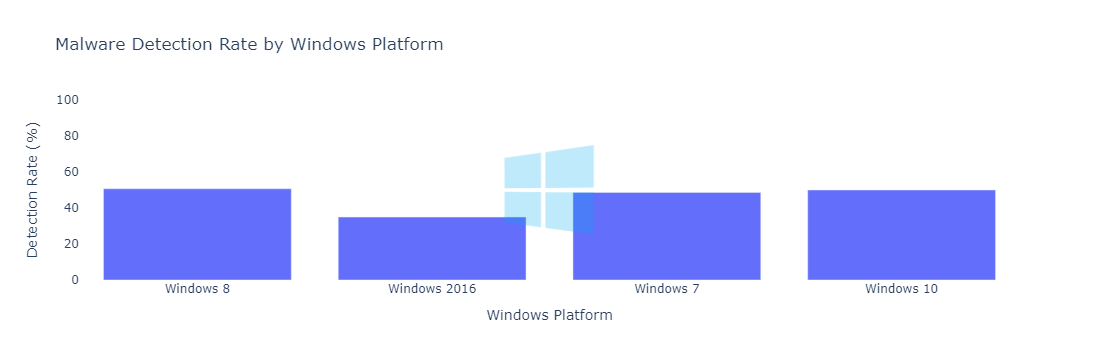

In [32]:
import plotly.graph_objects as go

# Data from mapreduce results
platforms = ['Windows 8', 'Windows 2016', 'Windows 7', 'Windows 10']
detection_rates_platform = [0.5067, 0.3496, 0.4865, 0.5000]

# Convert detection rates to percentages
detection_rates_percent = [round(rate * 100, 2) for rate in detection_rates_platform]


# Plot
fig = go.Figure(data=[go.Bar(x=platforms, y=detection_rates_percent)])

# Adding Windows logo as a background image
fig.add_layout_image(
    dict(
        source="https://upload.wikimedia.org/wikipedia/commons/5/5f/Windows_logo_-_2012.svg",
        xref="paper", yref="paper",
        x=0.5, y=0.5, 
        sizex=0.5, sizey=0.5,  
        xanchor="center", yanchor="middle",
        opacity=0.25  
    )
)

# Update layout
fig.update_layout(
    title='Malware Detection Rate by Windows Platform',
    xaxis_title='Windows Platform',
    yaxis_title='Detection Rate (%)', 
    yaxis=dict(range=[0, 100]), 
    plot_bgcolor='white'  
)

# Show plot
fig.show()


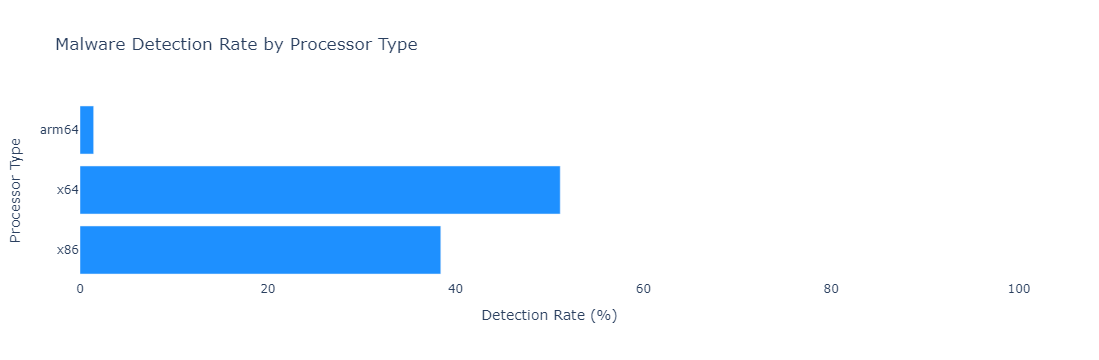

In [33]:
import plotly.graph_objects as go

# Data for processors and their detection rates
processors = ['x86', 'x64', 'arm64']
detection_rates_processors = [0.3842, 0.5114, 0.0145]

# Convert detection rates to percentages
detection_rates_percent = [round(rate * 100, 2) for rate in detection_rates_processors]

# Plot
fig = go.Figure(data=[go.Bar(x=detection_rates_percent, y=processors, orientation='h', marker_color='dodgerblue')])

# Update layout
fig.update_layout(
    title='Malware Detection Rate by Processor Type',
    xaxis_title='Detection Rate (%)',
    yaxis_title='Processor Type',
    xaxis=dict(range=[0, 100]), 
    plot_bgcolor='white'
)

# Show plot
fig.show()


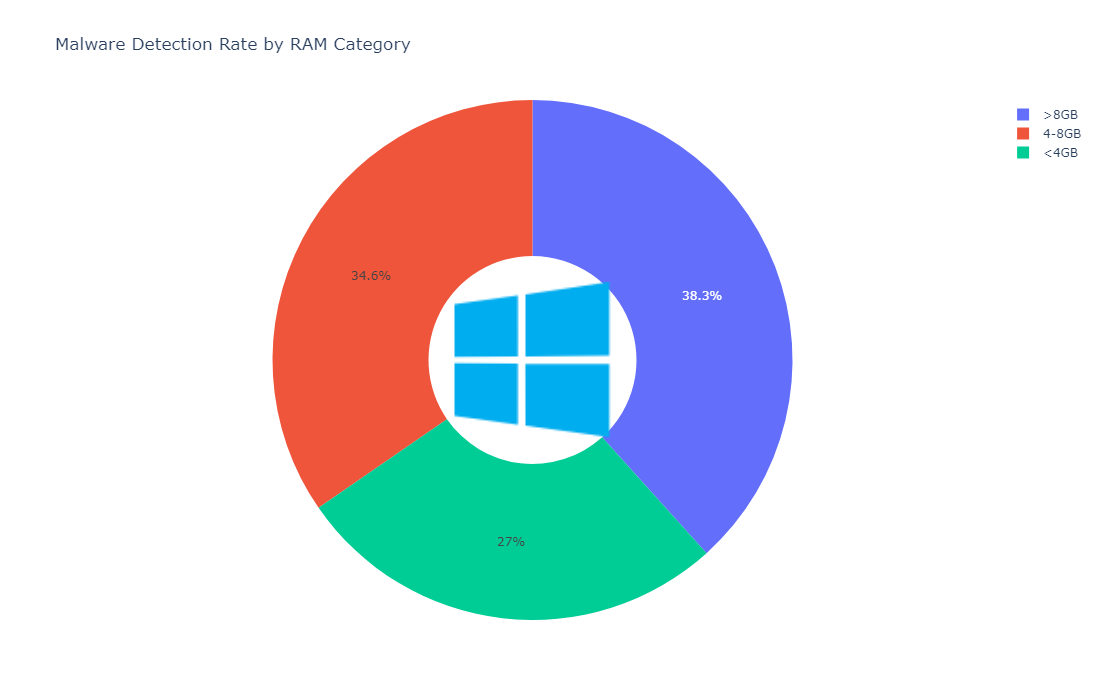

In [47]:
import plotly.graph_objects as go

# Data for RAM categories and their detection rates
ram_categories = ['>8GB', '4-8GB', '<4GB']
detection_rates_ram = [0.5665, 0.5118, 0.3998]

# Convert detection rates to percentages
detection_rates_percent = [round(rate * 100, 2) for rate in detection_rates_ram]

# Plot the pie chart with increased size
fig = go.Figure(data=[go.Pie(labels=ram_categories, values=detection_rates_percent, hole=.4)])


fig.update_layout(
    title='Malware Detection Rate by RAM Category',
    annotations=[dict(text='', x=0.5, y=0.5, font_size=20, showarrow=False)],
    images=[dict(
        source="https://upload.wikimedia.org/wikipedia/commons/5/5f/Windows_logo_-_2012.svg",
        xref="paper", yref="paper",
        x=0.5, y=0.5,
        sizex=0.3, sizey=0.3,  # Increase size of the logo
        xanchor="center", yanchor="middle",
        layer="above"
    )],
    width=700, 
    height=700 
)

# Show plot
fig.show()
